In [ ]:
# Install dependencies
# ---------------------------

!pip install numpy
!pip install matplotlib
!pip install opencv-python
!pip install pandas
!pip install seaborn

In [1]:
# Import dependencies
# ---------------------------

import time, os, sys, pickle, random, cv2,
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Javascript, display, Markdown, clear_output

print("Python version: {}".format(sys.version_info))
print("Numpy version: {}".format(np.version.version))
print("Tensorflow version: {}".format(tf.__version__))

# Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',titleweight='bold', titlesize=16, titlepad=20)
plt.rc('image', cmap='magma')

Python version: sys.version_info(major=3, minor=8, micro=10, releaselevel='final', serial=0)
Numpy version: 1.22.1
Tensorflow version: 2.7.0


In [ ]:
# Download dataset
# ---------------------------

!curl -LO https://physics.sh/galaxyclass-data.zip
!unzip -q -n galaxyclass-data.zip -d data
!rm galaxyclass-data.zip

In [2]:
# Data loader
# ---------------------------

directory = 'data/'
model_dir = directory + "models/"
training_dir = directory + "images_training/"
test_dir = directory + "images_test/"

labels = pd.read_csv(directory + 'training_solutions.csv')
images = [f for f in os.listdir(training_dir) if os.path.isfile(os.path.join(training_dir, f))]
labels.GalaxyID = labels.GalaxyID.apply(lambda id: str(int(id)) + '.jpg')

label_desc = ['Smooth','Featured or disc','Star or artifact','Edge on','Not edge on','Bar through center',
        'No bar','Spiral','No Spiral','No bulge','Just noticeable bulge','Obvious bulge','Dominant bulge',
        'Odd Feature','No Odd Feature','Completely round','In between','Cigar shaped','Ring (Oddity)',
        'Lens or arc (Oddity)','Disturbed (Oddity)','Irregular (Oddity)','Other (Oddity)','Merger (Oddity)',
        'Dust lane (Oddity)','Rounded bulge','Boxy bulge','No bulge','Tightly wound arms','Medium wound arms',
        'Loose wound arms','1 Spiral Arm','2 Spiral Arms','3 Spiral Arms','4 Spiral Arms','More than four Spiral Arms',"Can't tell"]

groups = [
          ['Class1.1', 'Class1.2', 'Class1.3'],
          ['Class2.1', 'Class2.2'],
          ['Class3.1', 'Class3.2'],
          ['Class4.1', 'Class4.2'],
          ['Class5.1', 'Class5.2', 'Class5.3', 'Class5.4'],
          ['Class6.1', 'Class6.2'],
          ['Class7.1', 'Class7.2', 'Class7.3'],
          ['Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6', 'Class8.7'],
          ['Class9.1','Class9.2','Class9.3'],
          ['Class10.1', 'Class10.2', 'Class10.3'],
          ['Class11.1','Class11.2','Class11.3','Class11.4','Class11.5','Class11.6']
]

!mkdir -p data/processed/150x150
DIR_150 = directory + "processed/150x150/"

## Exploratory Data Analysis

The objective of my exploratory data analysis was to get a better understanding of the dataset, I wanted to learn about how the classes are distributed, as well as how the galaxies are displayed in the images, to then better inform my preprocessing and deep learning strategies. For a start, this is what the highest confidence example for each feature looks like. Keep in mind that the classes are still representing a decision tree.

### The highest confidence example for each feature

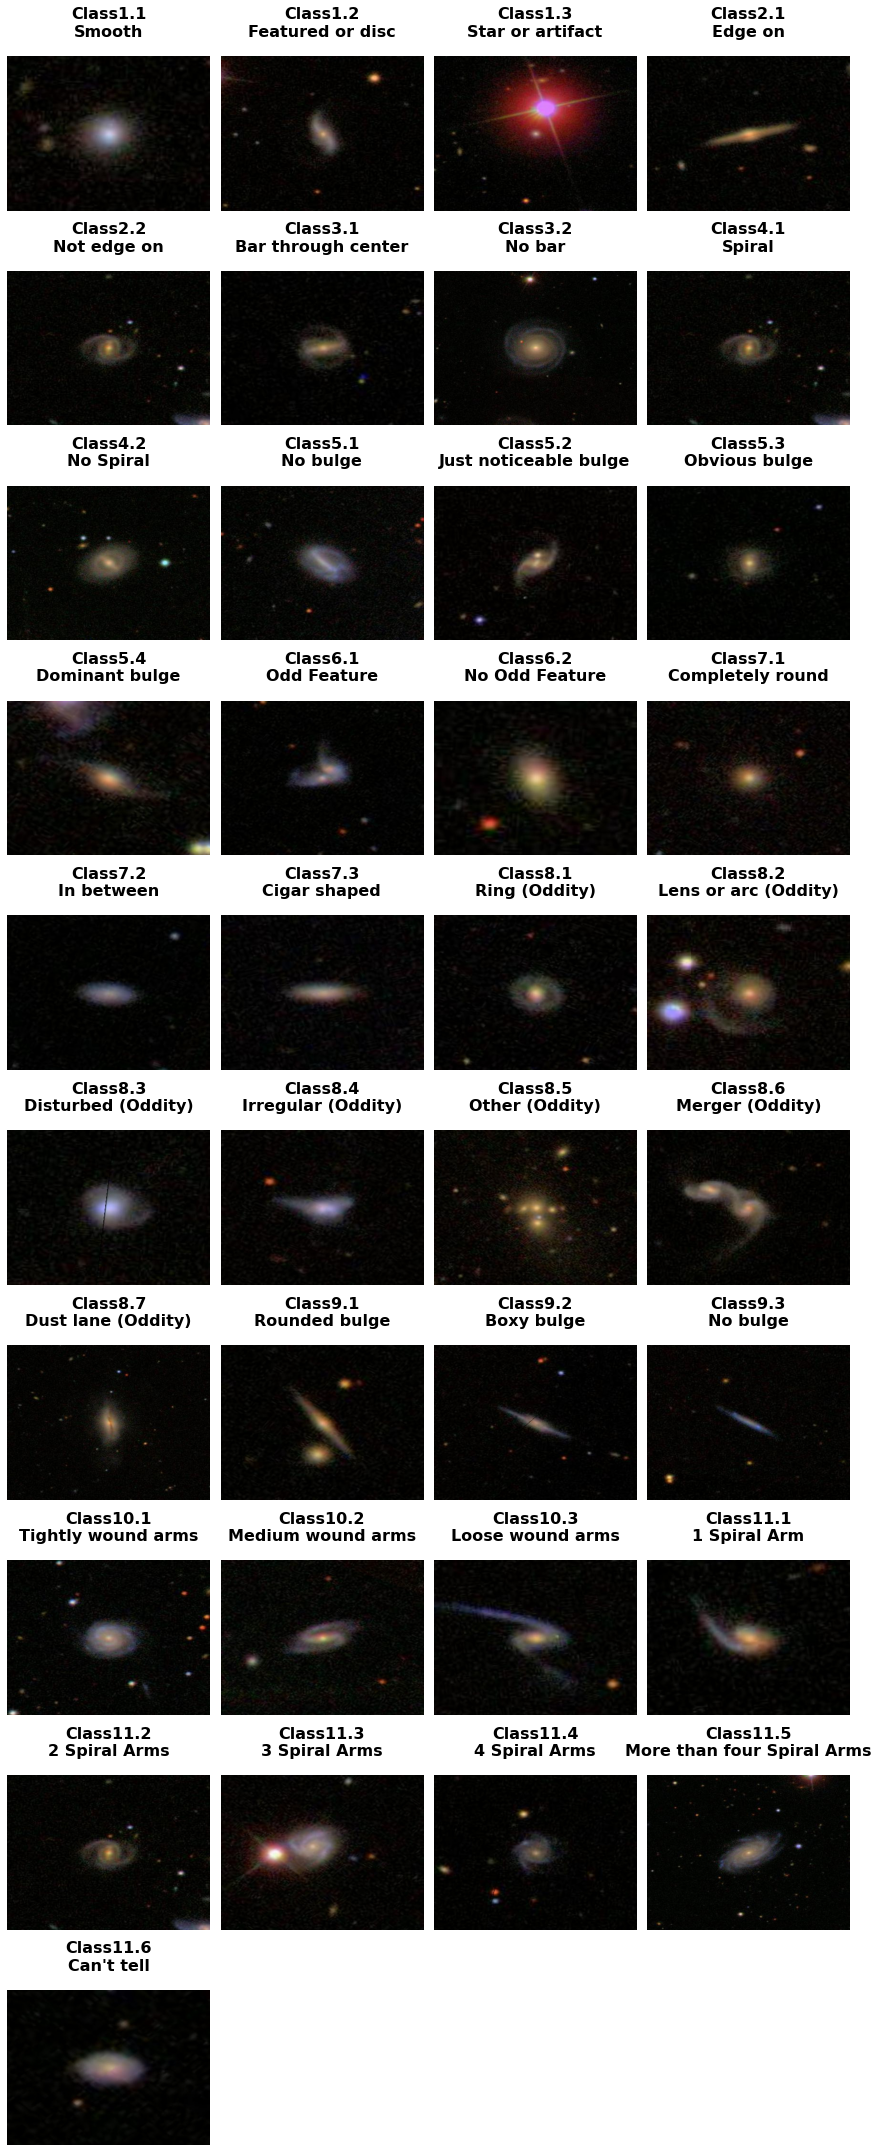

In [5]:
display(Markdown("### The highest confidence example for each feature"))
size = 12
fig = plt.figure('', figsize=[size,size*10/4])
plt.axis('off')
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
for i, feature in enumerate(labels.columns[1:]):
    fig.add_subplot(10, 4, i+1)
    plt.title(feature + "\n" + label_desc[i]) 
    plt.axis('off')
    plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
    file = labels.iloc[labels[feature].idxmax()].GalaxyID
    img = plt.imread(training_dir + file, format='jpg')
    plt.imshow(img, aspect='auto', cmap='gray')
fig.tight_layout(pad=1.0)
plt.show()

In [3]:
display(labels)

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008.jpg,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.000000,0.000000,0.0,0.325512
1,100023.jpg,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.000000,0.000000,0.0,0.000000
2,100053.jpg,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,100078.jpg,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.000000,0.000000,0.0,0.000000
4,100090.jpg,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61573,999948.jpg,0.510379,0.489621,0.000000,0.059207,0.430414,0.000000,0.430414,0.226257,0.204157,...,0.000000,0.226257,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.226257
61574,999950.jpg,0.901216,0.098784,0.000000,0.000000,0.098784,0.000000,0.098784,0.000000,0.098784,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
61575,999958.jpg,0.202841,0.777376,0.019783,0.116962,0.660414,0.067245,0.593168,0.140022,0.520391,...,0.000000,0.000000,0.090673,0.049349,0.000000,0.067726,0.000000,0.000000,0.0,0.072296
61576,999964.jpg,0.091000,0.909000,0.000000,0.045450,0.863550,0.022452,0.841098,0.795330,0.068220,...,0.000000,0.068398,0.318132,0.408799,0.227464,0.408799,0.090668,0.023065,0.0,0.045334


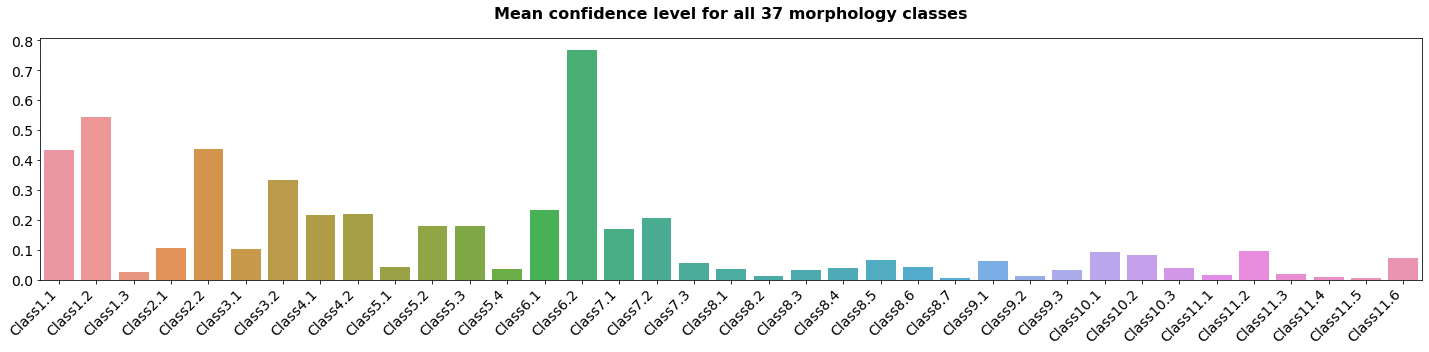

In [6]:
title = 'Mean confidence level for all 37 morphology classes'
plt.figure(figsize=(20, 5))
plt.title(title)
sns.barplot(x= labels.drop('GalaxyID', axis=1, inplace=False).mean().index, 
            y = labels.drop('GalaxyID', axis=1, inplace=False).mean().values)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.show()

The first thing I looked at was the instances of all classes where the confidence level was above 0.5. This is interesting to me as it will show the classes which are common and which are sparse in the dataset, and my main questions regarding this was whether I needed to apply weights to the loss function. If the classes were all evenly distributed, I could use an out of the box loss function. If not, I would need to write one that applies weights to prevent the neural network from over-prioritizing classes where there isn’t enough data to effectively learn.

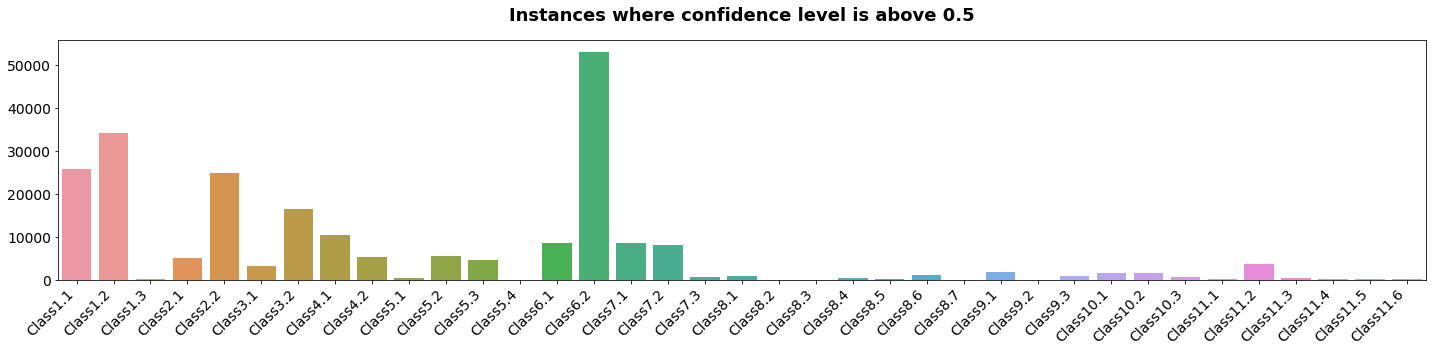

In [7]:
title = 'Instances where confidence level is above 0.5'
plt.figure(figsize=(20, 5))
plt.title(title, fontsize=18)
sns.barplot(x= labels.columns[1:] ,
            y = np.where(labels.drop('GalaxyID', axis=1, inplace=False).to_numpy() >= 0.5, 1, 0).sum(axis=0))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.show()

As you can see, the classes

- 6.2 (No odd feature)
- 1.2 (Featured or disc)
- 2.2 (Not edge on)
- 1.1 (Smooth)

are dominating the dataset, which makes sense, as most galaxies in the night sky would share atleast one or more features from this list.
We can also see that stars and artifacts (Class 1.3) are extremely rare in this dataset with only 44 instances; pretty much 0%. This means that we won't have to build a model that filters out these anomalies.
Following that I wanted to find out how strongly the participants agreed with each other. As we don’t really have a single source of truth, we’re not really modeling which galaxies have which features but we are actually measuring how confident the human scorers is that a galaxy has a certain attribute.
To understand this better, I plotted correlation matrices for the answers to each question as heatmaps.

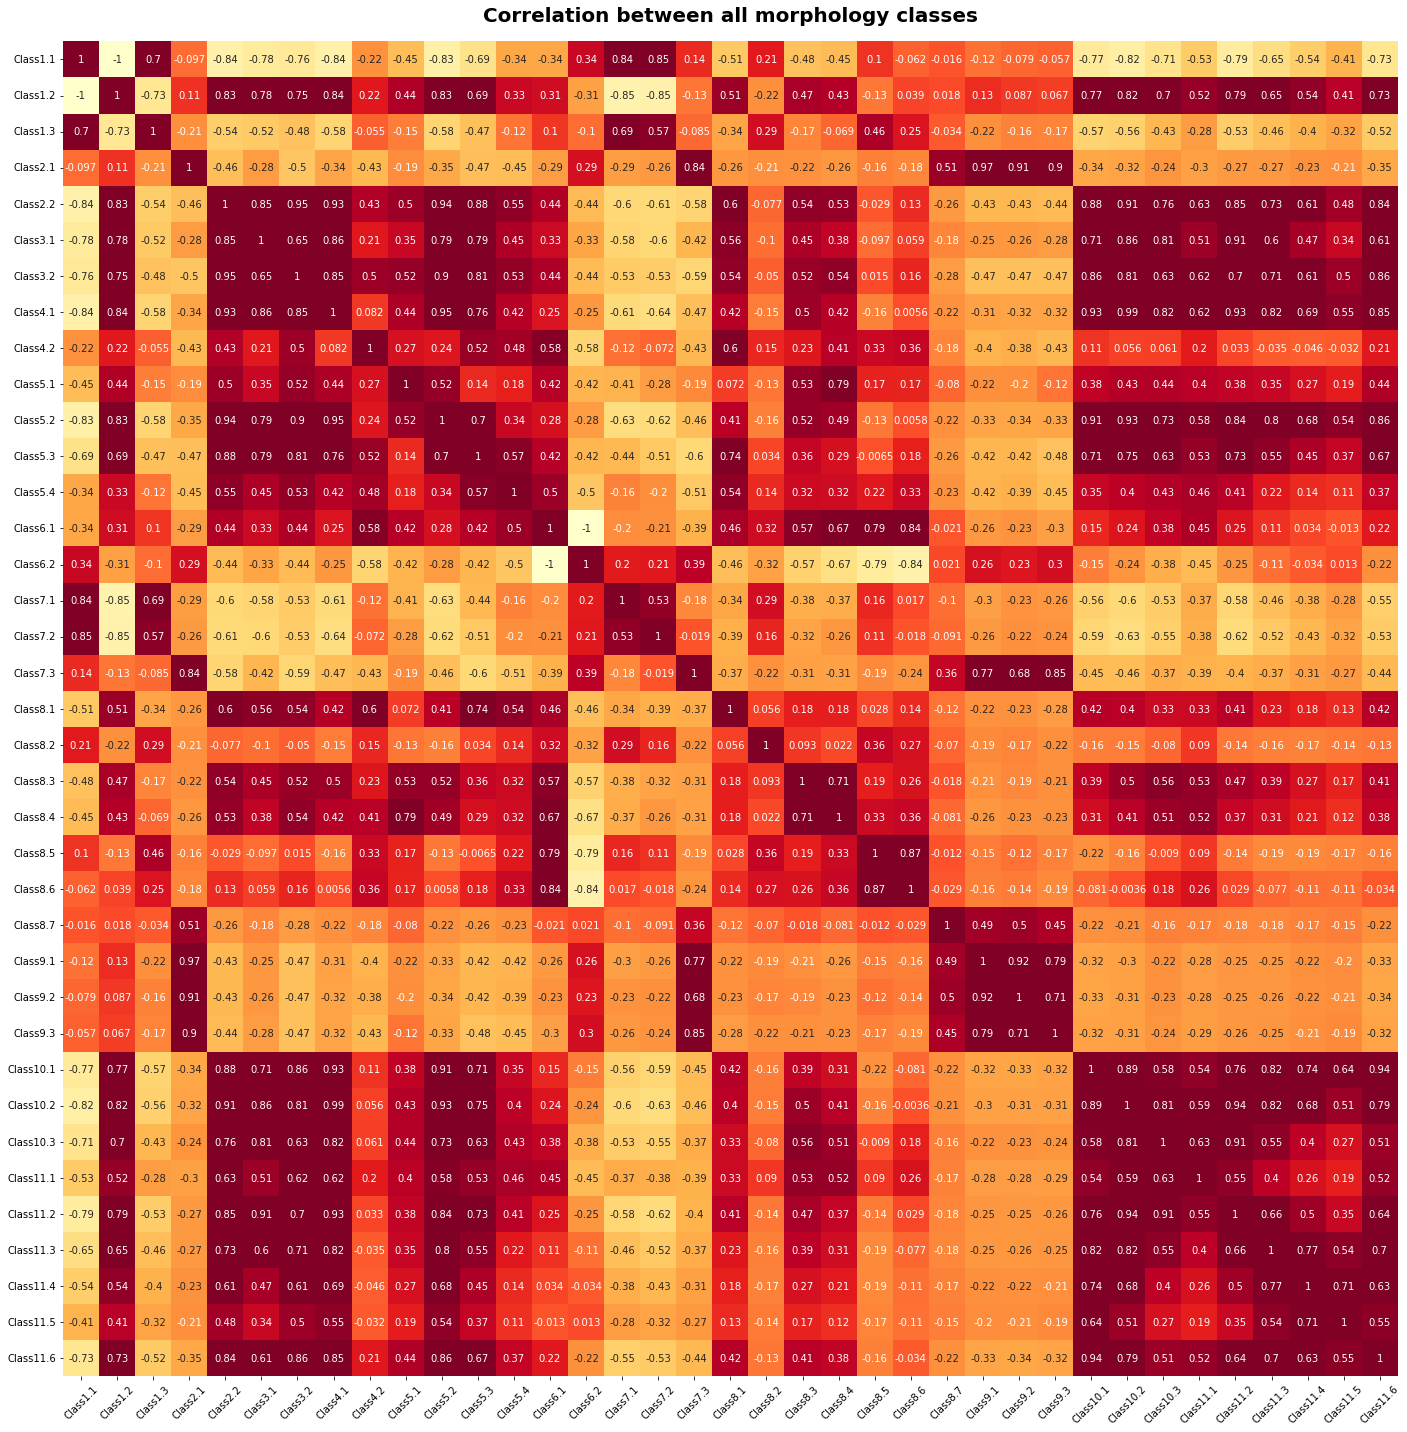

In [14]:
def heatmap(df, title):
    plt.figure(title, figsize=[20,20])
    plt.title(title, fontsize=20)
    df_corr = df.corr()
    sns.heatmap(df_corr, vmax=0.6, square=True, annot=True, cmap='YlOrRd', cbar=False)
    plt.yticks(rotation = 0)
    plt.xticks(rotation = 45)
    plt.show()

heatmap(labels.corr(), 'Correlation between all morphology classes')

This heatmap gives an overview of the correlations between all answers to every question.
We can observe that the relatively rare Class1.3 (stars or other non-galaxies) is correlated with the path through Class1.1 to ambiguous shapes and odd attribtes. Labelers may have confused galaxies with odd appearances and stars. Things like this are a reminder that hand-labeled data does not represent the absolute truth, but rather an approximation.

We can also see from the negative correlation between Class6.1 and Class6.2 that disagreement over whether an images had an odd feature was rare. Although there is high correlation between Class8.3/4/6 , which means that there was some confusion between disturbed, irregular, and merged galaxies.

Zooming into the individual questions shows us how well humans can discern between different attributes.

### Correlation heatmaps for each question

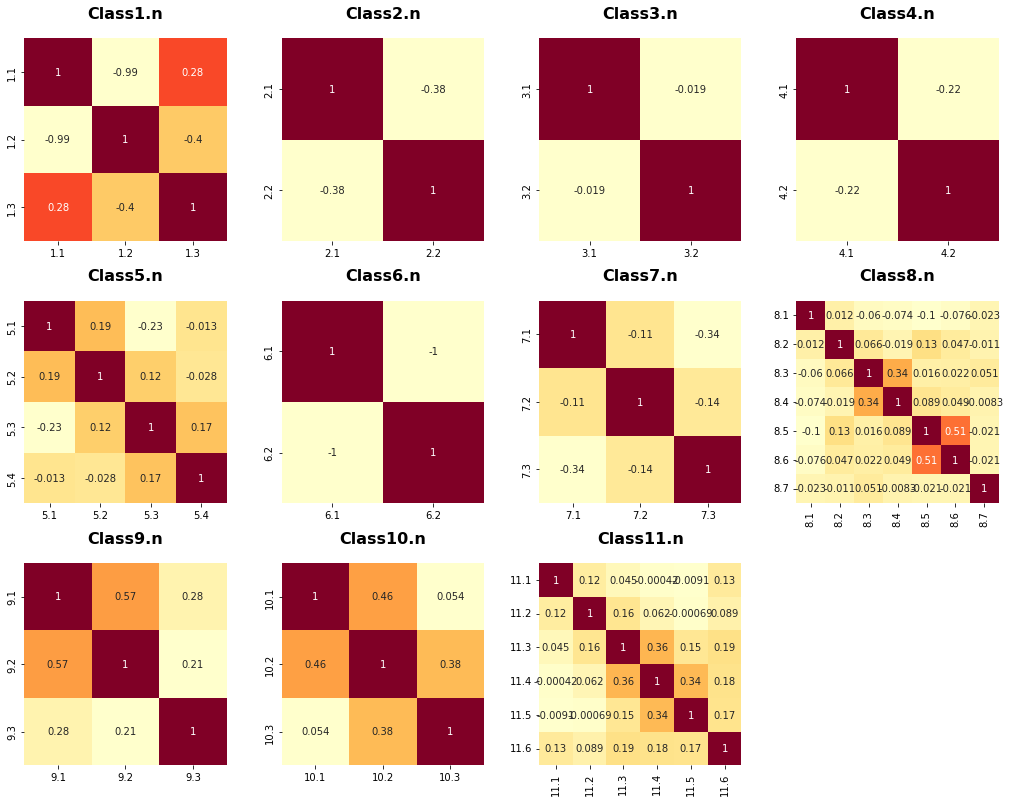

In [13]:
display(Markdown("### Correlation matrices for each of the 11 questions"))
size = 15
fig = plt.figure("Individual classes heatmaps", figsize=[size,size*3/4])
for i, group in enumerate(groups):
    fig.add_subplot(3, 4, i+1)
    plt.title('Class' + str(i+1) + '.n') 
    sns.heatmap(labels[group].corr(), square=True, annot=True,  cmap='YlOrRd', cbar=False)
    plt.xticks([x + 0.5 for x in range(len(group))], labels=[s.replace('Class','') for s in group])
    plt.yticks([y + 0.5 for y in range(len(group))], labels=[s.replace('Class','') for s in group])
fig.tight_layout(pad=3.0)
plt.show()

Class6.n shows us the ideal case where it is very unlikely for people to disagree over the galaxies with odd features, while Class9.n reveals that there is regularly confusion over the shape of the bulges and even over whether or not a bulge is present.